### Import modules

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors 
import matplotlib.cm as cm

import h5py 
import glob
import os 
import pickle

from datetime import datetime
import pytz

import scipy
from scipy.fftpack import fft,ifft 
from scipy.linalg import svd
import pywt

full_blues = mpl.colormaps['Blues'].resampled(256)
new_blues = colors.ListedColormap(full_blues(np.linspace(0.2,1,256)))


### Import icewave packages

In [2]:
# auto reload modules 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Users/sebas/git')

import icewave.tools.matlab2python as mat2py
import icewave.tools.matlab_colormaps as matcmaps
import icewave.tools.Fourier_tools as FT
import icewave.das.DAS_package as DS
import icewave.sebastien.set_graphs as set_graphs

# PARULA COLORMAP 
parula_map = matcmaps.parula()

plt.rcParams.update({
    "text.usetex": True}) # use latex

global g
g = 9.81

### Function section

In [3]:
#%% FUNCTION SECTION 

def plot_spatio_temp(spatio,fiber_length,extents,cmap):
    """ Plot spatio-temporal using specific format
    Inputs: - spatio, numpy 2D array [nt,nx],
            - fiber_length, float, length of fiber, as set in Febus software
    Outputs: - fig, matplotlib figure
             - ax, matplotlib axis object
             - imsh, matplotlib imshow object
             - cbar, matplotlib colorbar object """
    
    
    normalization = 'linear'
    fig,ax = plt.subplots()
    imsh = ax.imshow(spatio.T,origin = 'lower',aspect = 'auto',norm = normalization, cmap = cmap,
              interpolation = 'gaussian', extent = extents)
    ax.set_ylim([0,fiber_length])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    cbar = plt.colorbar(imsh,cax = cax)

    ax.set_xlabel(r'$t \; \mathrm{(s)}$',labelpad = 5)
    ax.set_ylabel(r'$s \; \mathrm{(m)}$',labelpad = 5)
    
    return fig,ax,imsh,cbar

#----------------------------------------------------------------------------------------------------

def shallow_hydroelastic(k,D,rho_w,H):
    """ Compute shallow hydroelastic dispersion relation
    Inputs: - k, numpy array, wavevector array
            - D, float  or numpy array, flexural modulus
            - rho_w, float or numpy array, water density
            - H, float or numpy array, water depth 
            
    Outputs : - omega, numpy array, pulsation given by shallow hydroelastic dispersion relation """
    
    omega = np.sqrt((g*k + D/rho_w*k**5)*np.tanh(H*k))
    
    return omega

#-------------------------------------------------------------------------------------------------------

def get_water_height(DAS_water_height,UTC_t,selected_x):
    """ Compute water height for a given UTC datetime and position along the fiber
    Input : - DAS_water_height, dictionnary containing recording of water depth evolution during the whole experiment 
            - UTC_t, datetime object, time at which we look for water height
            - selected_x, float, position along optical fiber in meter 
    Output : H, float, water height at the selected time and position 
    """

    closest_idx = np.argmin(abs(UTC_t - DAS_water_height['UTC_t']))
    closest_idx_pos = np.argmin(abs(selected_x - DAS_water_height['s']))
    H = DAS_water_height['water_height'][closest_idx_pos,closest_idx]
    return H

### Load DAS

In [4]:
#%% load DAS parameters and data 

date = '0211'

# Load parameters for DAS
path2DAS_param = 'U:/Data/parameters_Febus_2025.pkl'
with open(path2DAS_param,'rb') as pf:
    param = pickle.load(pf)
print('Parameters file loaded')

# Set parameters
# fs = np.shape(strain_rate)[1] # time sampling frequency 
# facq_x = np.shape(strain_rate)[2]/fiber_length # spatial sampling frequency
fs = param[date]['fs']
fiber_length = param[date]['fiber_length'] # fiber length in meters (set on DAS)
facq_x = param[date]['facq_x'] 

path2data = f'F:/Rimouski_2025/Data/{date}/DAS/'

# Create folder for saving graphs
fig_folder = f'{path2data}Figures/'
if not os.path.isdir(fig_folder):
    os.mkdir(fig_folder)

filelist = glob.glob(path2data + '*.h5')
Nb_minutes = 1 # duration of each stack

idx_file = -1
file2load = filelist[idx_file]
stack_strain,stack_time,UTC_stack,s = DS.stack_data_fromfile(file2load, fiber_length, Nb_minutes)


Parameters file loaded
['fa1-20050033']
Created 10 stacks of duration 1 minutes
Spatio-temp computed for a total number of seconds : 60
Spatio-temp computed for a total number of seconds : 60
Spatio-temp computed for a total number of seconds : 60
Spatio-temp computed for a total number of seconds : 60
Spatio-temp computed for a total number of seconds : 60
Spatio-temp computed for a total number of seconds : 60
Spatio-temp computed for a total number of seconds : 60
Spatio-temp computed for a total number of seconds : 60
Spatio-temp computed for a total number of seconds : 60
Spatio-temp computed for a total number of seconds : 60


In [10]:
print(filelist)

['F:/Rimouski_2025/Data/0211/DAS\\_2025-02-11_18-42-43_UTC.h5', 'F:/Rimouski_2025/Data/0211/DAS\\_2025-02-11_18-52-43_UTC.h5', 'F:/Rimouski_2025/Data/0211/DAS\\_2025-02-11_19-02-43_UTC.h5', 'F:/Rimouski_2025/Data/0211/DAS\\_2025-02-11_19-12-43_UTC.h5', 'F:/Rimouski_2025/Data/0211/DAS\\_2025-02-11_19-22-43_UTC.h5', 'F:/Rimouski_2025/Data/0211/DAS\\_2025-02-11_19-32-43_UTC.h5', 'F:/Rimouski_2025/Data/0211/DAS\\_2025-02-11_19-42-43_UTC.h5', 'F:/Rimouski_2025/Data/0211/DAS\\_2025-02-11_18-32-43_UTC.h5']


### Plot spatio-temporal

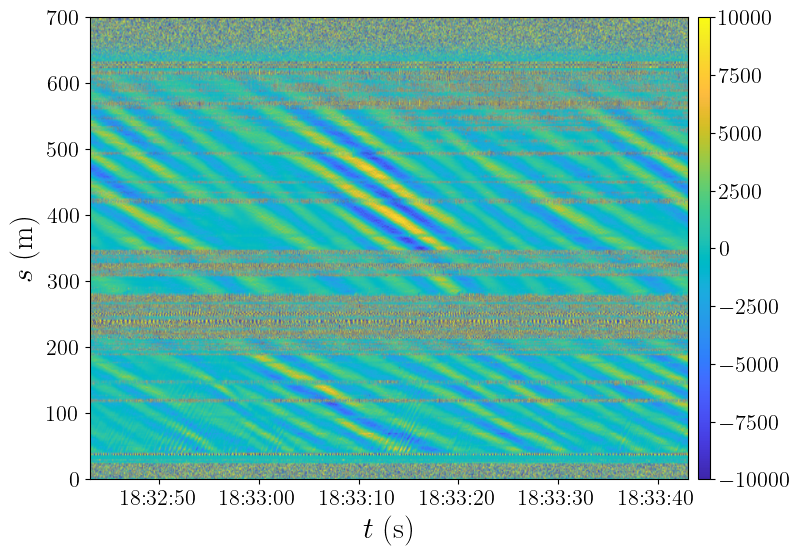

In [8]:
chunk = 0
set_graphs.set_matplotlib_param('single')
extents = [UTC_stack[chunk,0],UTC_stack[chunk,-1],s[0],s[-1]]
fig, ax ,imsh, cbar = plot_spatio_temp(stack_strain[chunk,:,:], fiber_length, extents, parula_map)
imsh.set_clim([-1e4,1e4])

### Perform Fourier Transform in time

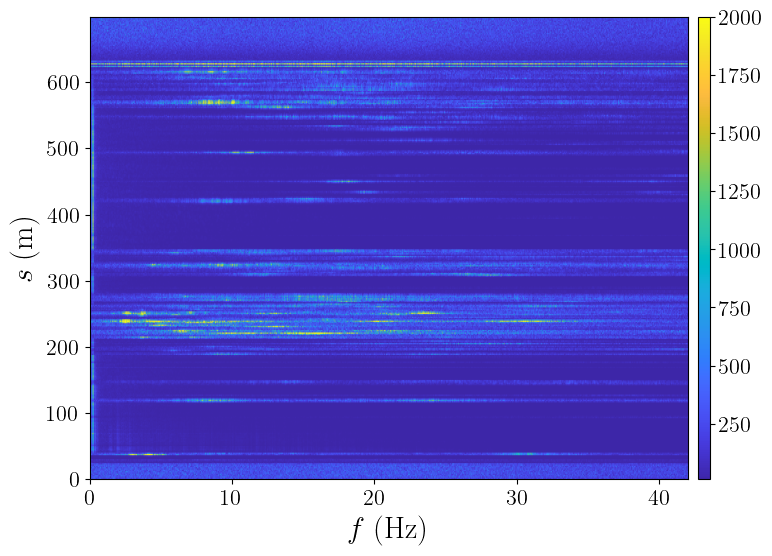

In [6]:
N = 2**(FT.nextpow2(stack_strain.shape[1]))

mean_sig = np.mean(stack_strain,axis = 1)
mean_sig = np.tile(mean_sig,(stack_strain.shape[1],1,1)).transpose((1,0,2))

FFT_t = np.fft.fft(stack_strain - mean_sig,n = N,axis = 1)
FFT_t = FFT_t/stack_strain.shape[1]

# keep only half of frequencies
FFT_t = FFT_t[:,:N//2,:]
FFT_t[:,1:-1,:] = 2*FFT_t[:,1:-1,:]

freq = fs*np.arange(0,(N/2))/N

fig, ax = plt.subplots()
imsh = ax.imshow(abs(FFT_t[chunk,:,:]).T,origin = 'lower',cmap = parula_map, aspect = 'auto',
          extent = [freq[0],freq[-1],s[0],s[-1]])
imsh.set_clim([1e1,2e3])

ax.set_xlabel(r'$f \; \mathrm{(Hz)}$')
ax.set_ylabel(r'$s \; \mathrm{(m)}$')
# ax.set_xlim([0,10])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)

### Plot Profile for a given frequency 

Text(0, 0.5, '$\\hat{\\dot{\\epsilon}}(s)$')

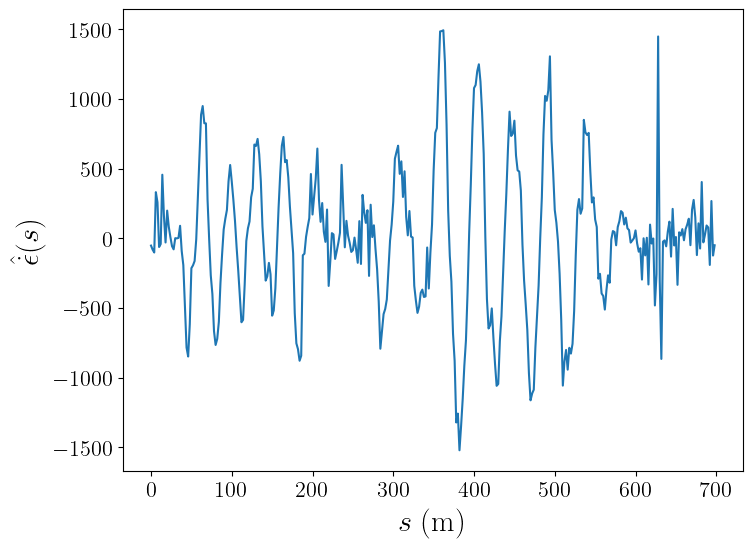

In [7]:
selected_freq = 0.2
idx_freq = np.argmin(abs(freq - selected_freq))

profile = FFT_t[0,idx_freq,:]

fig, ax = plt.subplots()
ax.plot(s,np.real(profile))
ax.set_xlabel(r'$s \; \mathrm{(m)}$')
ax.set_ylabel(r'$\hat{\dot{\epsilon}}(s)$')

### Select wavelet and plot

(-5.0, 5.0)

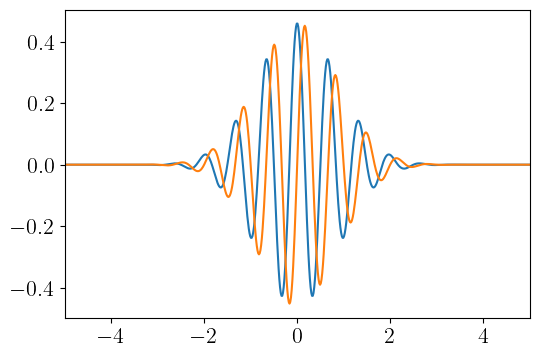

In [63]:
wavelet = 'cmor1.5-1.5' # mother wavelet 
[psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)

fig, axs = plt.subplots(figsize = (6,4))
axs.plot(x,np.real(psi))
axs.plot(x,np.imag(psi))
axs.set_xlim([-5,5])

### Select scales and perform Continuous Wavelet Transform (CWT)

In [119]:
sampling_period = 1/facq_x #spatial sampling wavelength
#logarithmic scales
scales = np.geomspace(2,1024,num = 200)

# compute normalized wavenumber (sigma)
norm_sigma = pywt.scale2frequency(wavelet,scales)
wavelength_sampled = sampling_period/norm_sigma # typical wavelength that will be sampled 
print(f'Wavelengths sampled : min = {wavelength_sampled[0]:.2f} m, max = {wavelength_sampled[-1]:.2f} m')

# compute cwt
cwtmatr, freqs = pywt.cwt(np.real(profile), scales, wavelet, sampling_period = sampling_period)

Wavelengths sampled : min = 2.67 m, max = 1365.33 m


### Plot Scaleogram

Text(0.5, 1.0, 'Continuous Wavelet Transform (scaleogram)')

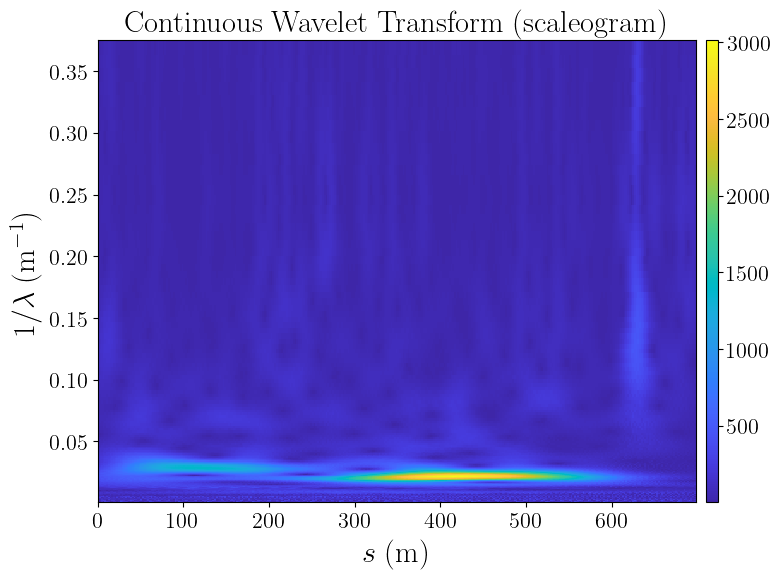

In [120]:
fig, ax = plt.subplots()
imsh = ax.pcolormesh(s,freqs,abs(cwtmatr[:-1,:-1]),cmap = parula_map)
ax.set_xlabel(r'$s \; \mathrm{(m)}$')
ax.set_ylabel(r'$1/\lambda \; \mathrm{(m^{-1})}$')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
ax.set_title(r'Continuous Wavelet Transform (scaleogram)')
# ax.set_ylim([0.001,0..05])

### Compute CWT for all time frequencies $f$

In [122]:
# parameters for CWT
sampling_period = 1/facq_x #spatial sampling wavelength
#logarithmic scales
scales = np.geomspace(2,1024,num = 200)

# compute normalized wavenumber (sigma)
norm_sigma = pywt.scale2frequency(wavelet,scales)
wavelength_sampled = sampling_period/norm_sigma # typical wavelength that will be sampled 
print(f'Wavelengths sampled : min = {wavelength_sampled[0]:.2f}, max = {wavelength_sampled[-1]:.2f}')

# selection of chunk
current_chunk = 0
current_FFT = FFT_t[current_chunk,:,:]

CWT = np.zeros((current_FFT.shape[0],len(scales),current_FFT.shape[1]),dtype = 'complex')
for i in range(current_FFT.shape[0]): # loop over time frequencies 
    cwtmatr, sigmas = pywt.cwt(current_FFT[i,:], scales, wavelet, sampling_period = sampling_period)
    CWT[i,:,:] = cwtmatr

Wavelengths sampled : min = 2.67, max = 1365.33


### Plot $(f,k)$ for a given position 

25
[np.float64(0.000732421875), np.float64(0.375), np.float64(0.0), np.float64(41.98974609375)]


Text(0.5, 1.0, 's = 50.00 m ')

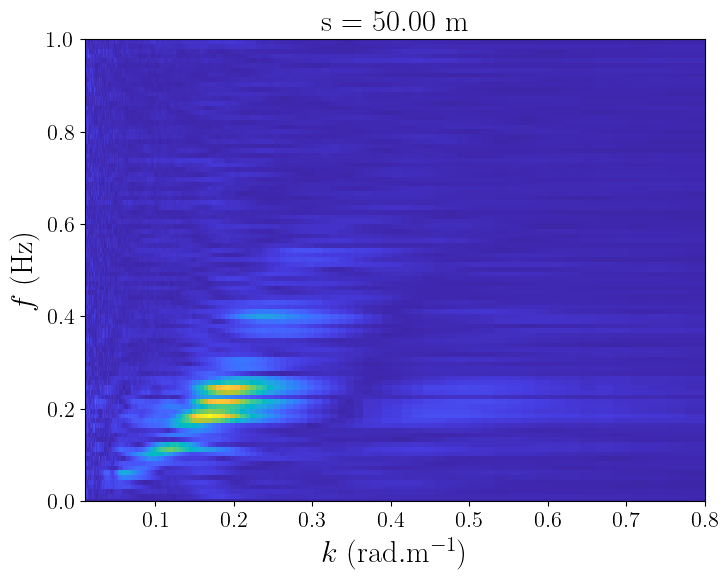

In [132]:
selected_x = 50 # distance from interogator
idx_x = np.argmin(abs(s - selected_x))
print(idx_x)

extents = [sigmas.min(),sigmas.max(),freq[0],freq[-1]]
print(extents)
fig, ax = plt.subplots()
imsh = ax.pcolormesh(2*np.pi*sigmas,freq,abs(CWT[:,:,idx_x]),cmap = parula_map)
ax.set_ylim([0,1])
ax.set_xlim([0.01,0.8])

ax.set_xlabel(r'$k \; \mathrm{(rad.m^{-1})}$')
ax.set_ylabel(r'$f \; \mathrm{(Hz)}$')
ax.set_title(f's = {s[idx_x]:.2f} m ')

### Plot $(f,k)$ for several different positions

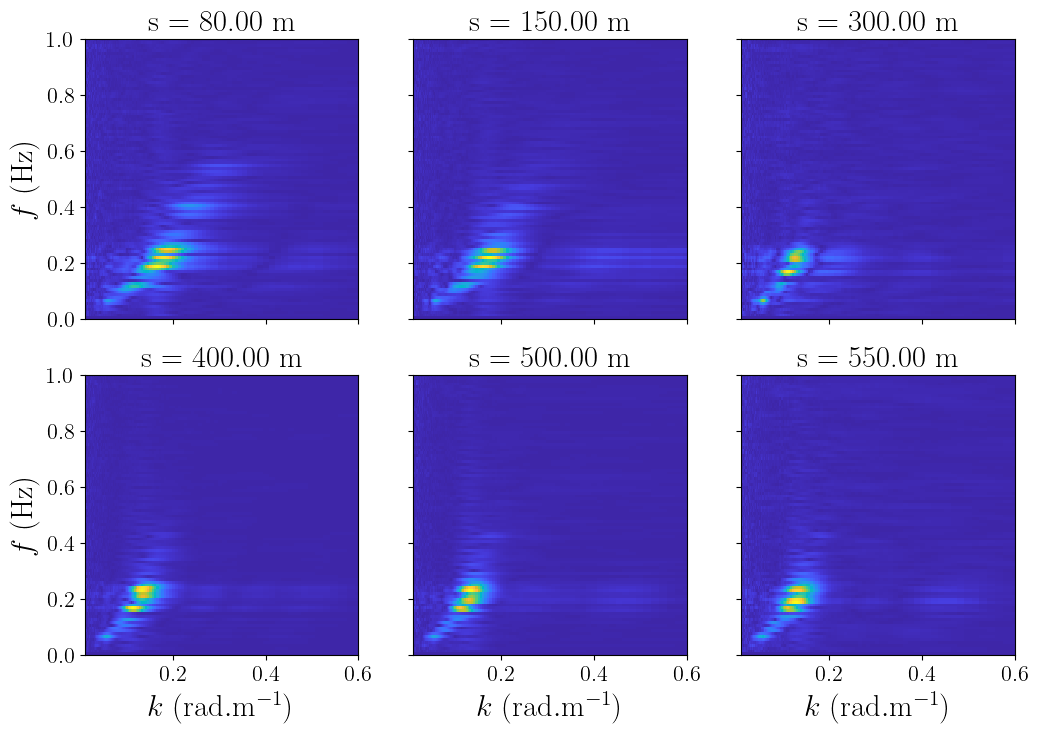

In [124]:
selected_x = np.array([80,150,300,400,500,550])
idx_x = [np.argmin(abs(s - x)) for x in selected_x]

fig, axs = plt.subplots(nrows = 2, ncols = 3, sharex = True, sharey = True,figsize = (12,8))
for ax, idx in zip(axs.flatten(),idx_x):
    imsh = ax.pcolormesh(2*np.pi*sigmas,freq,abs(CWT[:-1,:-1,idx]),cmap = parula_map)
    ax.set_ylim([0,1])
    ax.set_xlim([0.01,0.6])
    # ax.set_ylim([0,8])
    # ax.set_xlim([0,0.7])
    ax.set_title(f's = {s[idx]:.2f} m')

for j in range(axs.shape[1]):
    axs[1,j].set_xlabel(r'$k \; \mathrm{(rad.m^{-1})}$')

for i in range(axs.shape[0]):
    axs[i,0].set_ylabel(r'$f \; \mathrm{(Hz)}$')

### Threshold spectrum

Text(0.5, 0, '$k \\; \\mathrm{(rad.m^{-1})}$')

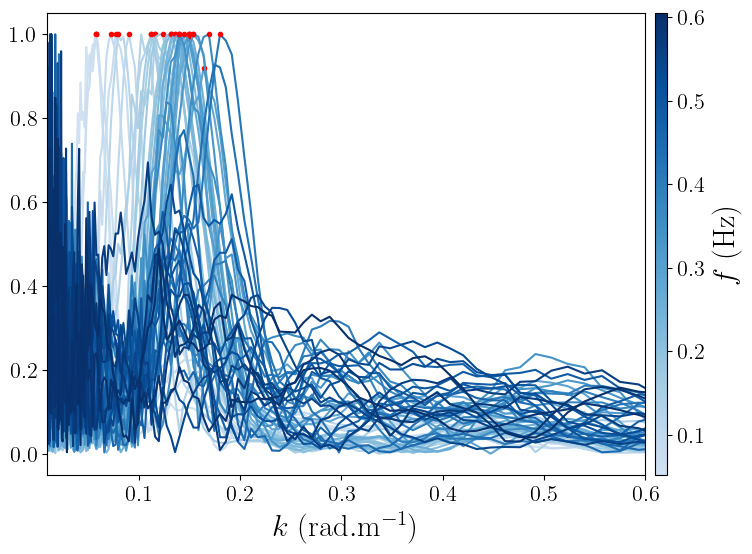

In [229]:
selected_x = 550
idx_x = np.argmin(abs(s - selected_x))

freq_min = 0.05
freq_max = 0.6
idx_min = np.argmin(abs(freq - freq_min))
idx_max = np.argmin(abs(freq - freq_max))

indices = np.arange(idx_min,idx_max + 1, step = 1)

# define norm for colormaps
norm = colors.Normalize(vmin = freq[idx_min], vmax = freq[idx_max])

min_prominence = 0.9
min_width = 10
# min_height = 0.9

dict_peaks = {}
fig, ax = plt.subplots()

for idx_freq in indices:
# print(f'frequency = {freq[idx_freq]:.2f} Hz')
    current_cwt_max = np.max(abs(CWT[idx_freq,:,idx_x]))
    # find peaks
    peaks,properties = scipy.signal.find_peaks(abs(CWT[idx_freq,:,idx_x])/current_cwt_max,
                                               prominence = min_prominence,width = min_width)
    if len(peaks) != 0:
        dict_peaks[str(idx_freq)] = peaks
    current_color = new_blues(norm(freq[idx_freq]))
    ax.plot(2*np.pi*sigmas,abs(CWT[idx_freq,:,idx_x])/current_cwt_max,color = current_color)
    ax.plot(2*np.pi*sigmas[peaks],abs(CWT[idx_freq,peaks,idx_x])/current_cwt_max,'r.')

ax.set_xlim([0.01,0.6])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

sm = cm.ScalarMappable(cmap=new_blues, norm=norm)
sm.set_array([])  # Only needed for the colorbar
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label(r'$f \; \mathrm{(Hz)} $')
ax.set_xlabel(r'$k \; \mathrm{(rad.m^{-1})}$')


In [230]:
# create arrays from peak detection 
k_exp = []
f_exp = []
for key in list(dict_peaks.keys()):
    p = dict_peaks[key]
    f = freq[int(key)]
    for peak in p:
        k_exp.append(2*np.pi*sigmas[peak])
        f_exp.append(f)

k_exp = np.array(k_exp)
f_exp = np.array(f_exp)

### Collect water depth 

In [19]:
path2water_DAS = f'U:/Data/{date}/DAS/'
file2load = glob.glob(f'{path2water_DAS}fiber_water_height_GPS_structure_{date}.pkl')[0]
with open(file2load,'rb') as pf:
    DAS_water_height = pickle.load(pf)

Text(0, 0.5, '$H \\; \\mathrm{(m)}$')

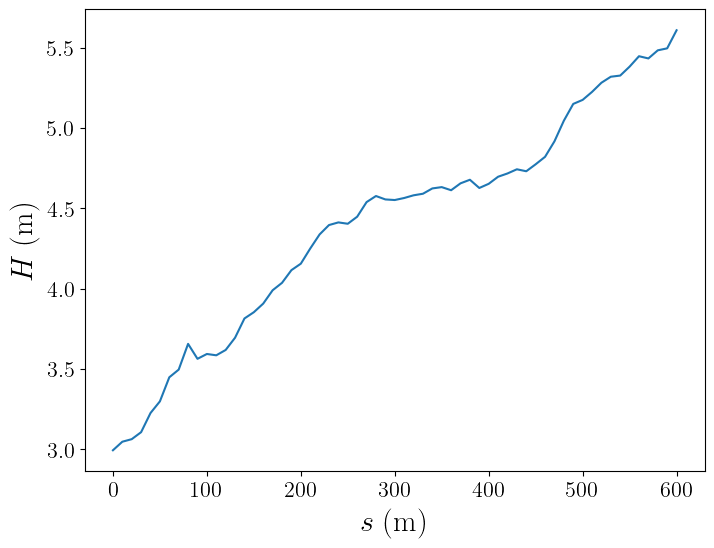

In [234]:
UTC_chunk = UTC_stack[chunk,0] #initial UTC time of the studied chunk 
# get closest registered UTC time 
closest_idx = np.argmin(abs(UTC_chunk - DAS_water_height['UTC_t']))
water_profile = DAS_water_height['water_height'][:,closest_idx]

fig, ax = plt.subplots()
ax.plot(DAS_water_height['s'],water_profile)
ax.set_xlabel('$s \; \mathrm{(m)}$')
ax.set_ylabel('$H \; \mathrm{(m)}$')


In [236]:
H = get_water_height(DAS_water_height,UTC_chunk,550)
print(H)

5.38165034674169


### Plot detected points and get estimate of flexural modulus $D$

D = 4.23e+07 ± 3.07e+06


Text(0, 0.5, '$f \\; \\mathrm{(Hz)}$')

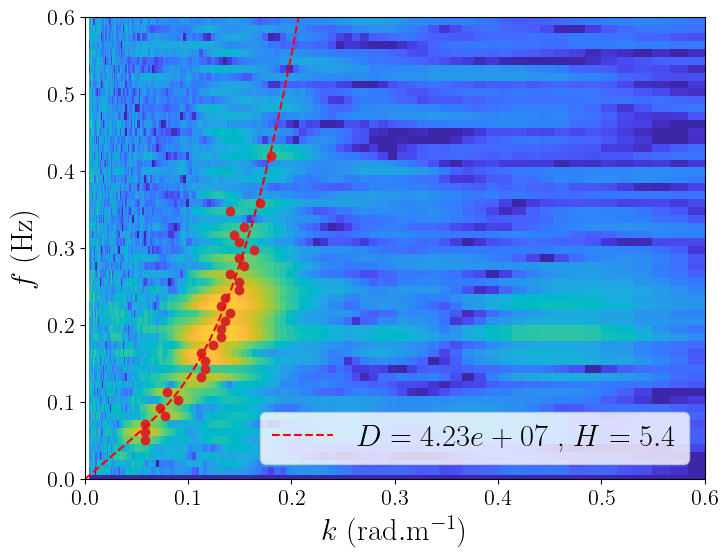

In [237]:
fig, ax = plt.subplots()
imsh = ax.pcolormesh(2*np.pi*sigmas,freq,np.log10(abs(CWT[:,:,idx_x])),cmap = parula_map,vmin = 1,vmax = 4)

ax.plot(k_exp,f_exp,'o',color = 'tab:red')

rho_w = 1027
H = get_water_height(DAS_water_height,UTC_chunk,selected_x)
popt,pcov = scipy.optimize.curve_fit(lambda x,D : shallow_hydroelastic(x, D, rho_w, H)/2/np.pi,k_exp,f_exp,
                                     bounds = (1e5,1e8))

err_coeff = np.sqrt(np.diag(pcov))
print(f'D = {popt[0]:.2e} ± {err_coeff[0]:.2e}')

k_th = np.linspace(0,1,100)
omega_th = shallow_hydroelastic(k_th, popt, rho_w, H)
label_th = r'$D = ' + f'{popt[0]:.2e}' + r'$ , $H = ' + f'{H:.1f}' + r'$'
ax.plot(k_th,omega_th/2/np.pi,'r--',label = label_th)

ax.legend(loc = 'lower right')

ax.set_ylim([0,0.6])
ax.set_xlim([0,0.6])
ax.set_xlabel(r'$k \; \mathrm{(rad.m^{-1})}$')
ax.set_ylabel(r'$f \; \mathrm{(Hz)}$')

### Extract flexural modulus $D$ for different positions 

In [17]:
def extract_peaks(FK,freq,k,freq_range,min_prominence,min_width):
    """ Extract peak coordinates from a space-time spectrum 
    Inputs : - FK, numpy 2D array [nf,nk], space-time spectrum
             - freq, numpy array (nf,), frequencies
             - k, numpy array (nk,), wavevectors
             - freq_range, tuple [freq_min, freq_max], frequency range within we look for peaks
             - min_prominence, minimum prominence of peaks once a row is normalized (see scipy.signal.findpeaks)
             - min_width, minimal width of peaks once a row is normalized (see scipy.signal.findpeaks)
             
    Outputs : - k_exp, array of peaks wavevector coordinate
              - f_exp, array of peaks frequency coordinate """
    
    freq_min = freq_range[0]
    freq_max = freq_range[1]
    idx_min = np.argmin(abs(freq - freq_min))
    idx_max = np.argmin(abs(freq - freq_max))

    indices = np.arange(idx_min,idx_max + 1, step = 1)

    # create arrays for peak detection 
    k_exp = []
    f_exp = []
    
    for idx_freq in indices:
    # print(f'frequency = {freq[idx_freq]:.2f} Hz')
        current_max = np.max(abs(FK[idx_freq,:]))
        # find peaks
        peaks,properties = scipy.signal.find_peaks(abs(FK[idx_freq,:])/current_max,
                                                   prominence = min_prominence,width = min_width)
        if len(peaks) != 0:
            for peak in peaks:
                k_exp.append(k[peak])
                f_exp.append(freq[idx_freq])
    
    k_exp = np.array(k_exp)
    f_exp = np.array(f_exp)

    return k_exp,f_exp

D = 5.33e+06 ± 2.87e+05
D = 8.65e+06 ± 6.51e+05
D = 6.45e+07 ± 4.30e+06
D = 4.85e+07 ± 3.02e+06
D = 5.22e+07 ± 5.99e+06
D = 4.23e+07 ± 2.99e+06


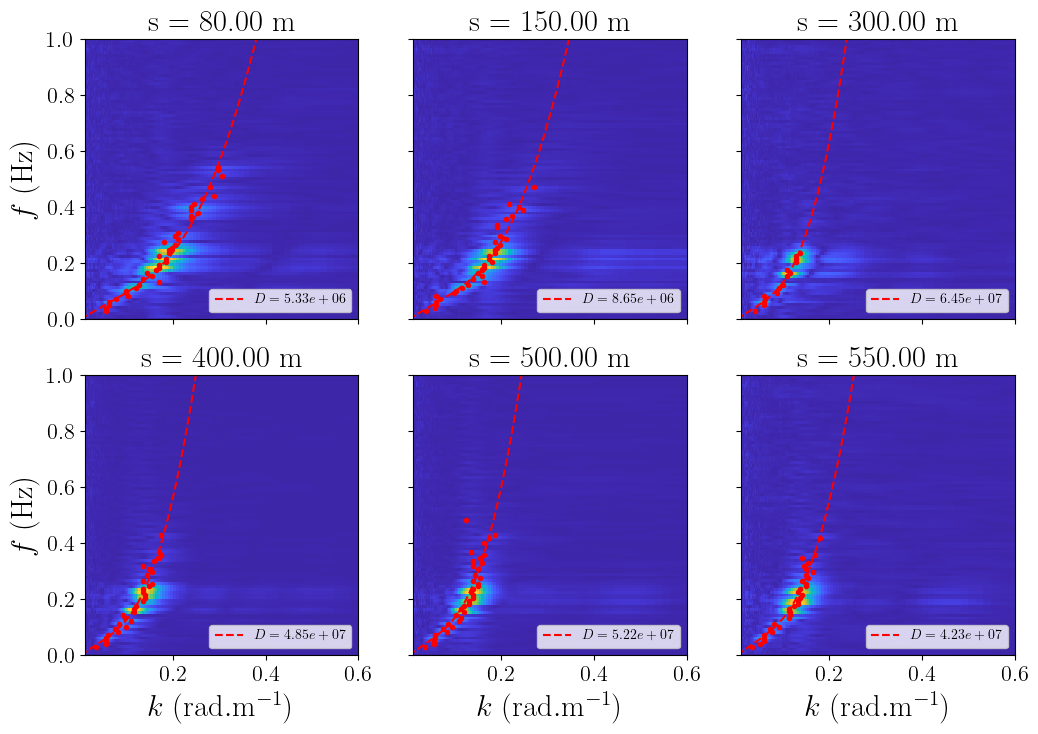

In [240]:
selected_x = np.array([80,150,300,400,500,550])
list_idx_x = [np.argmin(abs(s - x)) for x in selected_x]

D = np.zeros(len(selected_x))
err_D = np.zeros(len(selected_x))

freq_range = [0.02,0.6]
min_prominence = 0.9
min_width = 10

rho_w = 1027

fig, axs = plt.subplots(nrows = 2, ncols = 3, sharex = True, sharey = True,figsize = (12,8))
for i,(ax,idx_x) in enumerate(zip(axs.flatten(),list_idx_x)):
    FK = CWT[:,:,idx_x]
    imsh = ax.pcolormesh(2*np.pi*sigmas,freq,abs(FK),cmap = parula_map)
    ax.set_ylim([0,1])
    ax.set_xlim([0.01,0.6])
    # ax.set_ylim([0,8])
    # ax.set_xlim([0,0.7])
    ax.set_title(f's = {s[idx_x]:.2f} m')
    
    k_exp,f_exp = extract_peaks(FK,freq,2*np.pi*sigmas,freq_range,min_prominence,min_width)
    ax.plot(k_exp,f_exp,'r.')

    H = get_water_height(DAS_water_height,UTC_chunk,selected_x[i])
    popt,pcov = scipy.optimize.curve_fit(lambda x,D : shallow_hydroelastic(x, D, rho_w, H)/2/np.pi,k_exp,f_exp,
                                         bounds = (1e5,1e8))
    err_coeff = np.sqrt(np.diag(pcov))
    print(f'D = {popt[0]:.2e} ± {err_coeff[0]:.2e}')
    D[i] = popt[0]
    err_D[i] = err_coeff[0]

    k_th = np.linspace(0,1,100)
    omega_th = shallow_hydroelastic(k_th, D[i], rho_w, H)
    label_th = r'$D = ' + f'{popt[0]:.2e}' + r'$'
    ax.plot(k_th,omega_th/2/np.pi,'r--',label = label_th)
    ax.legend(loc = 'lower right',fontsize = 10)

for j in range(axs.shape[1]):
    axs[1,j].set_xlabel(r'$k \; \mathrm{(rad.m^{-1})}$')

for i in range(axs.shape[0]):
    axs[i,0].set_ylabel(r'$f \; \mathrm{(Hz)}$')   

figname = f'{fig_folder}{date}_subplots_D_extraction_chunk0_file0'
plt.savefig(f'{figname}.png',bbox_inches = 'tight')
plt.savefig(f'{figname}.pdf',bbox_inches = 'tight')

### Compute $D$ for several positions without plotting 

In [241]:
zone1 = np.arange(40,210,step = 20)
zone2 = np.arange(280,570,step = 20)
selected_x = np.concatenate((zone1,zone2))
list_idx_x = [np.argmin(abs(s - x)) for x in selected_x]

D = np.zeros(len(selected_x))
err_D = np.zeros(len(selected_x))

freq_range = [0.02,0.6]
min_prominence = 0.9
min_width = 10

rho_w = 1027

for i,idx_x in enumerate(list_idx_x):
    FK = CWT[:,:,idx_x]

    k_exp,f_exp = extract_peaks(FK,freq,2*np.pi*sigmas,freq_range,min_prominence,min_width)

    H = get_water_height(DAS_water_height,UTC_chunk,selected_x[i])
    popt,pcov = scipy.optimize.curve_fit(lambda x,D : shallow_hydroelastic(x, D, rho_w, H)/2/np.pi,k_exp,f_exp,
                                         bounds = (1e5,1e8))
    err_coeff = np.sqrt(np.diag(pcov))
    print(f'D = {popt[0]:.2e} ± {err_coeff[0]:.2e}')
    D[i] = popt[0]
    err_D[i] = err_coeff[0]


D = 7.53e+06 ± 5.84e+05
D = 6.18e+06 ± 4.19e+05
D = 5.33e+06 ± 2.87e+05
D = 6.63e+06 ± 3.50e+05
D = 7.60e+06 ± 6.01e+05
D = 7.53e+06 ± 5.49e+05
D = 9.99e+06 ± 9.04e+05
D = 1.09e+07 ± 1.19e+06
D = 1.14e+07 ± 1.36e+06
D = 5.79e+07 ± 8.57e+06
D = 6.45e+07 ± 4.30e+06
D = 5.75e+07 ± 3.41e+06
D = 4.81e+07 ± 2.54e+06
D = 4.88e+07 ± 1.95e+06
D = 4.69e+07 ± 2.62e+06
D = 4.85e+07 ± 3.02e+06
D = 4.65e+07 ± 3.21e+06
D = 4.91e+07 ± 2.91e+06
D = 4.70e+07 ± 2.52e+06
D = 4.77e+07 ± 3.33e+06
D = 5.22e+07 ± 5.99e+06
D = 4.82e+07 ± 4.23e+06
D = 4.37e+07 ± 2.73e+06
D = 4.19e+07 ± 2.75e+06


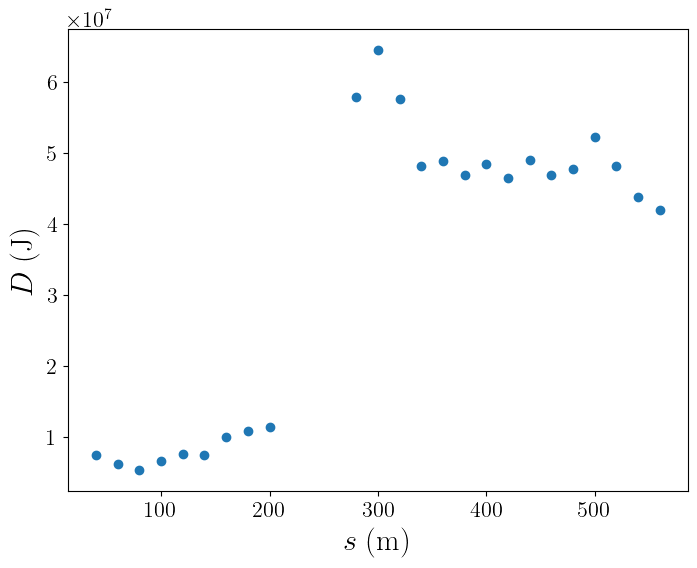

In [243]:
fig, ax = plt.subplots()
ax.plot(selected_x,D,'o')
ax.set_xlabel(r'$s \; \mathrm{(m)}$')
ax.set_ylabel(r'$D \; \mathrm{(J)}$')

figname = f'{fig_folder}{date}_D_VS_s_chunk0_file0'
plt.savefig(f'{figname}.png',bbox_inches = 'tight')
plt.savefig(f'{figname}.pdf',bbox_inches = 'tight')

# Extract $D$ by computing CWT on each chunk and then averaging the obtained FK

### Perform Fourier Transform in time

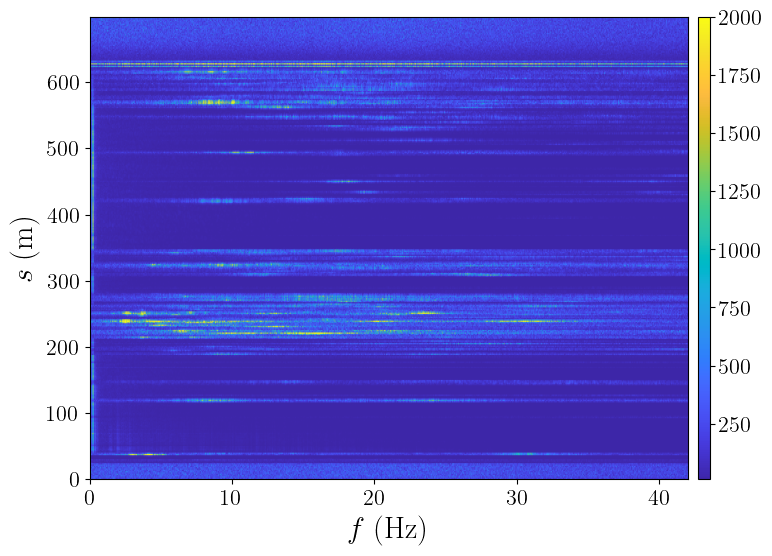

In [9]:
N = 2**(FT.nextpow2(stack_strain.shape[1]))

mean_sig = np.mean(stack_strain,axis = 1)
mean_sig = np.tile(mean_sig,(stack_strain.shape[1],1,1)).transpose((1,0,2))

FFT_t = np.fft.fft(stack_strain - mean_sig,n = N,axis = 1)
FFT_t = FFT_t/stack_strain.shape[1]

# keep only half of frequencies
FFT_t = FFT_t[:,:N//2,:]
FFT_t[:,1:-1,:] = 2*FFT_t[:,1:-1,:]

freq = fs*np.arange(0,(N/2))/N
chunk = 0
fig, ax = plt.subplots()
imsh = ax.imshow(abs(FFT_t[chunk,:,:]).T,origin = 'lower',cmap = parula_map, aspect = 'auto',
          extent = [freq[0],freq[-1],s[0],s[-1]])
imsh.set_clim([1e1,2e3])

ax.set_xlabel(r'$f \; \mathrm{(Hz)}$')
ax.set_ylabel(r'$s \; \mathrm{(m)}$')
# ax.set_xlim([0,10])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)

### Select wavelet

(-5.0, 5.0)

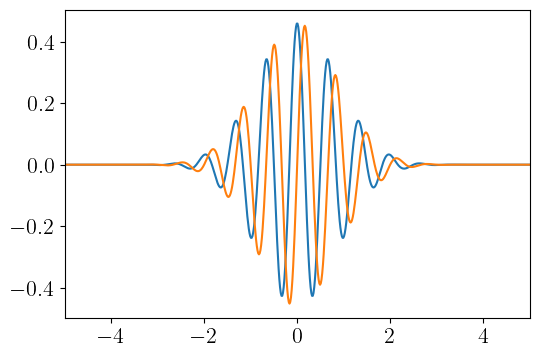

In [10]:
wavelet = 'cmor1.5-1.5' # mother wavelet 
[psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)

fig, axs = plt.subplots(figsize = (6,4))
axs.plot(x,np.real(psi))
axs.plot(x,np.imag(psi))
axs.set_xlim([-5,5])

### Compute CWT for all time chunks 

In [13]:
# parameters for CWT
sampling_period = 1/facq_x #spatial sampling wavelength
#logarithmic scales
scales = np.geomspace(2,1024,num = 100)

# compute normalized wavenumber (sigma)
norm_sigma = pywt.scale2frequency(wavelet,scales)
wavelength_sampled = sampling_period/norm_sigma # typical wavelength that will be sampled 
print(f'Wavelengths sampled : min = {wavelength_sampled[0]:.2f}, max = {wavelength_sampled[-1]:.2f}')

CWT = np.zeros((FFT_t.shape[0],FFT_t.shape[1],len(scales),FFT_t.shape[2]),dtype = 'complex')
# 0 : chunk_idx, # 1 : freq_idx, # 2 : scales, # 3 : space (curvilinear coordinate)

# loop over all chunks
for current_chunk in range(FFT_t.shape[0]):
    print(current_chunk)
    current_FFT = FFT_t[current_chunk,:,:]
    
    for i in range(current_FFT.shape[0]): # loop over time frequencies 
        cwtmatr, sigmas = pywt.cwt(current_FFT[i,:], scales, wavelet, sampling_period = sampling_period)
        CWT[current_chunk,i,:,:] = cwtmatr

Wavelengths sampled : min = 2.67, max = 1365.33


### Average norm of CWT over each chunk

In [34]:
mean_CWT = np.mean(abs(CWT),axis = 0)


In [47]:
mean_CWT.shape

(4096, 100, 350)

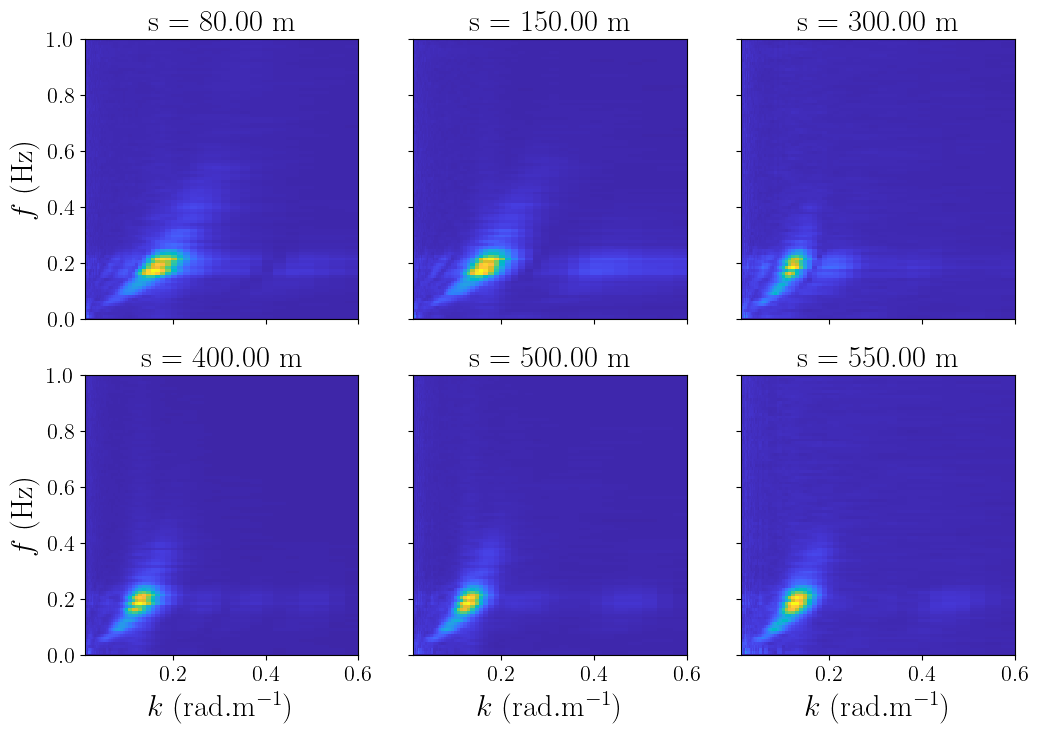

In [35]:
selected_x = np.array([80,150,300,400,500,550])
idx_x = [np.argmin(abs(s - x)) for x in selected_x]

fig, axs = plt.subplots(nrows = 2, ncols = 3, sharex = True, sharey = True,figsize = (12,8))
for ax, idx in zip(axs.flatten(),idx_x):
    imsh = ax.pcolormesh(2*np.pi*sigmas,freq,abs(mean_CWT[:,:,idx]),cmap = parula_map)
    ax.set_ylim([0,1])
    ax.set_xlim([0.01,0.6])
    # ax.set_ylim([0,10])
    # ax.set_xlim([0,1.0])
    ax.set_title(f's = {s[idx]:.2f} m')

for j in range(axs.shape[1]):
    axs[1,j].set_xlabel(r'$k \; \mathrm{(rad.m^{-1})}$')

for i in range(axs.shape[0]):
    axs[i,0].set_ylabel(r'$f \; \mathrm{(Hz)}$')

figname = f'{fig_folder}{date}_subplots_space_time_spectrum_spectrum_avg_file0'
plt.savefig(f'{figname}.png',bbox_inches = 'tight')
plt.savefig(f'{figname}.pdf',bbox_inches = 'tight')

### Compute $D$

In [44]:
zone1 = np.arange(40,210,step = 20)
zone2 = np.arange(280,570,step = 20)
selected_x = np.concatenate((zone1,zone2))
list_idx_x = [np.argmin(abs(s - x)) for x in selected_x]

D = np.zeros(len(selected_x))
err_D = np.zeros(len(selected_x))

freq_range = [0.02,0.6]
min_prominence = 0.9
min_width = 5

rho_w = 1027
UTC_chunk = UTC_stack[chunk,0] #initial UTC time of the studied chunk 
for i,idx_x in enumerate(list_idx_x):
    FK = abs(mean_CWT[:,:,idx_x])

    k_exp,f_exp = extract_peaks(FK,freq,2*np.pi*sigmas,freq_range,min_prominence,min_width)

    H = get_water_height(DAS_water_height,UTC_chunk,selected_x[i])
    popt,pcov = scipy.optimize.curve_fit(lambda x,D : shallow_hydroelastic(x, D, rho_w, H)/2/np.pi,k_exp,f_exp,
                                         bounds = (1e5,1e8))
    err_coeff = np.sqrt(np.diag(pcov))
    # print(f'D = {popt[0]:.2e} ± {err_coeff[0]:.2e}')
    D[i] = popt[0]
    err_D[i] = err_coeff[0]


# save data 
results_dict = {}
results_dict['D'] = D
results_dict['err_D'] = err_D
results_dict['x'] = selected_x

file2save = f'{path2data}{date}_wavelet_flexural_modulus_file_0.pkl'
with open(file2save, 'wb') as pf: 
    pickle.dump(results_dict,pf)

ValueError: `ydata` must not be empty!

In [45]:
k_exp

array([], dtype=float64)

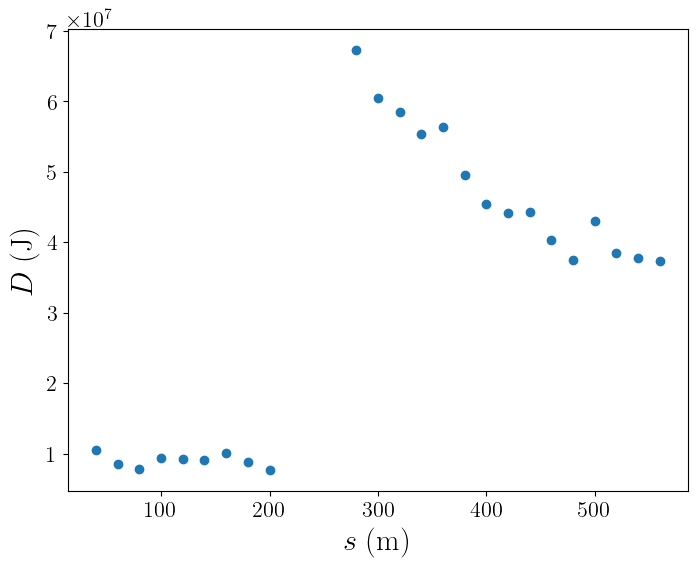

In [37]:
fig, ax = plt.subplots()
ax.plot(selected_x,D,'o')
ax.set_xlabel(r'$s \; \mathrm{(m)}$')
ax.set_ylabel(r'$D \; \mathrm{(J)}$')

figname = f'{fig_folder}{date}_D_VS_s_spectrum_avg_file0'
plt.savefig(f'{figname}.png',bbox_inches = 'tight')
plt.savefig(f'{figname}.pdf',bbox_inches = 'tight')

# Extract $D$ after averaging time FFT over all chunks

### FFT in time

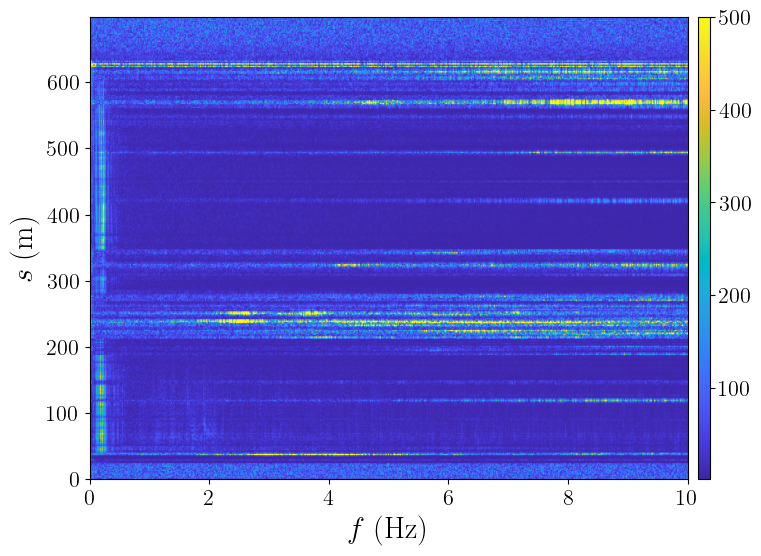

In [248]:
# FFT in time
N = 2**(FT.nextpow2(stack_strain.shape[1]))

mean_sig = np.mean(stack_strain,axis = 1)
mean_sig = np.tile(mean_sig,(stack_strain.shape[1],1,1)).transpose((1,0,2))

FFT_t = np.fft.fft(stack_strain - mean_sig,n = N,axis = 1)
FFT_t = FFT_t/stack_strain.shape[1]

# keep only half of frequencies
FFT_t = FFT_t[:,:N//2,:]
FFT_t[:,1:-1,:] = 2*FFT_t[:,1:-1,:]

freq = fs*np.arange(0,(N/2))/N

mean_FFT = np.mean(FFT_t,axis = 0)
fig, ax = plt.subplots()
imsh = ax.imshow(abs(mean_FFT).T,origin = 'lower',cmap = parula_map, aspect = 'auto',
          extent = [freq[0],freq[-1],s[0],s[-1]])
imsh.set_clim([1e0,5e2])

ax.set_xlabel(r'$f \; \mathrm{(Hz)}$')
ax.set_ylabel(r'$s \; \mathrm{(m)}$')
ax.set_xlim([0,10])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)

### Plot profile for a given frequency

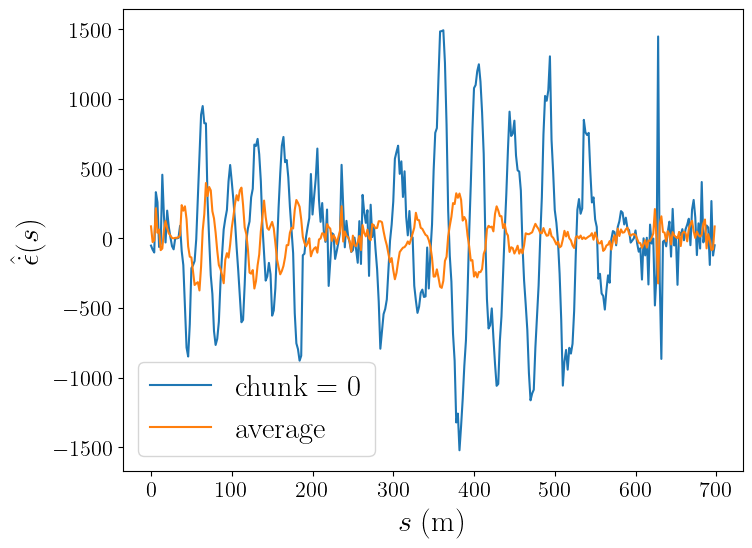

In [258]:
selected_freq = 0.2
idx_freq = np.argmin(abs(freq - selected_freq))

profile = FFT_t[chunk,idx_freq,:]

fig, ax = plt.subplots()
ax.plot(s,np.real(profile),label = f'chunk = {chunk}')
ax.plot(s,np.real(mean_FFT[idx_freq,:]),label = 'average')
ax.set_xlabel(r'$s \; \mathrm{(m)}$')
ax.set_ylabel(r'$\hat{\dot{\epsilon}}(s)$')

ax.legend()

### Wavelet selection 

(-5.0, 5.0)

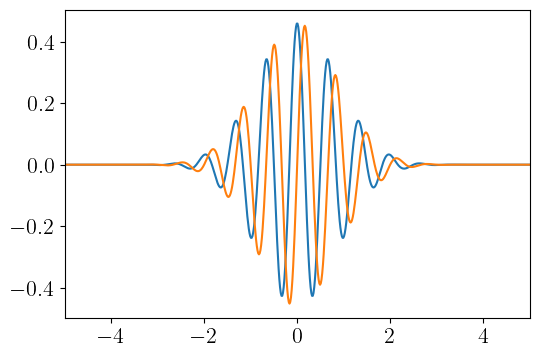

In [249]:
wavelet = 'cmor1.5-1.5' # mother wavelet 
[psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)

fig, axs = plt.subplots(figsize = (6,4))
axs.plot(x,np.real(psi))
axs.plot(x,np.imag(psi))
axs.set_xlim([-5,5])

In [38]:
fig_folder

'F:/Rimouski_2025/Data/0211/DAS/Figures/'

### Try to reconstruct initial signal

(200, 350)


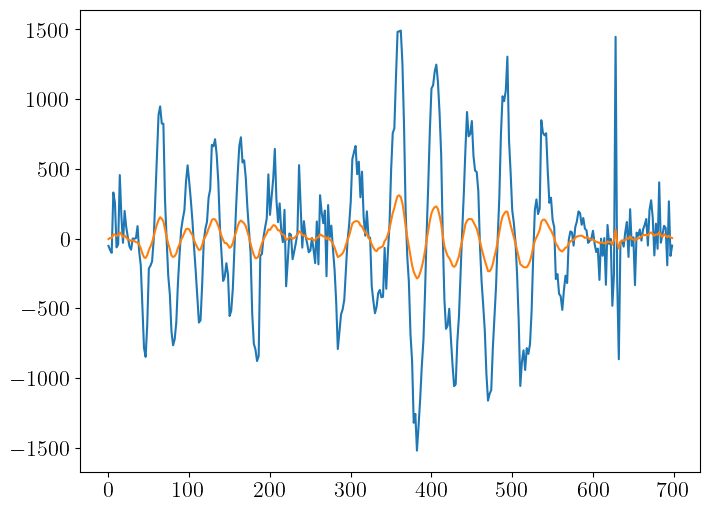

In [79]:
print(cwtmatr.shape)
reconstructed = np.mean(cwtmatr,axis = 0)

fig, ax = plt.subplots()
ax.plot(s,np.real(profile))
ax.plot(s,np.real(reconstructed))